In [1]:
import math
import json
import numpy as np
from collections import Counter
import pandas as pd
import random
from random import shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import svm
from numpy import linalg 
from sklearn.model_selection import GridSearchCV 
from random import randint

# Caculate TFIDF

In [2]:
with open('bbc_preprocessed.json') as f:
    data=json.load(f)
cate = [x["category"] for x in data]
map = {'Technology':0,'Entertainment & Arts':1,'Business':2,'Health':3,'Science & Environment':4}
categ = [map[x] for x in cate]
articles = [" ".join(x["content"]) for x in data]

In [3]:
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train, valid, train_categ, valid_categ = train_test_split(articles, categ, random_state=42)

def tfidf(train_articles, valid_articles):
    vectorizer = TfidfVectorizer(sublinear_tf = True, max_df=0.5, min_df = 5)
    train_features = vectorizer.fit_transform(train_articles)
    valid_features = vectorizer.transform(valid_articles)
    return train_features.todense(), valid_features.todense(), vectorizer
Train,Valid,vect = tfidf(train, valid)

/Users/ray/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
P = PCA(n_components = 50)
P.fit(Train)
visual = np.matrix(P.transform(Train))

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(visual)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11972 samples in 0.023s...
[t-SNE] Computed neighbors for 11972 samples in 13.583s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11972
[t-SNE] Computed conditional probabilities for sample 2000 / 11972
[t-SNE] Computed conditional probabilities for sample 3000 / 11972
[t-SNE] Computed conditional probabilities for sample 4000 / 11972
[t-SNE] Computed conditional probabilities for sample 5000 / 11972
[t-SNE] Computed conditional probabilities for sample 6000 / 11972
[t-SNE] Computed conditional probabilities for sample 7000 / 11972
[t-SNE] Computed conditional probabilities for sample 8000 / 11972
[t-SNE] Computed conditional probabilities for sample 9000 / 11972
[t-SNE] Computed conditional probabilities for sample 10000 / 11972
[t-SNE] Computed conditional probabilities for sample 11000 / 11972
[t-SNE] Computed conditional probabilities for sample 11972 / 11972
[t-SNE] Mean sigma: 0.089397
[t-SNE] KL divergen

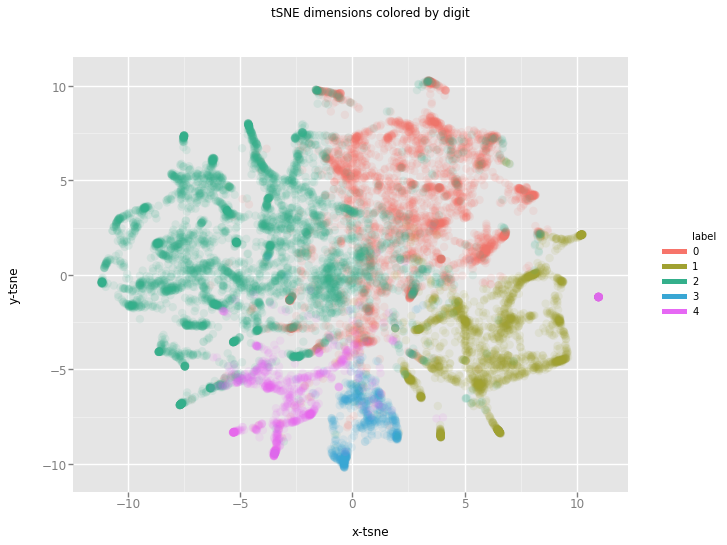

<ggplot: (-9223372029676608971)>

In [45]:
from ggplot import *

df_tsne = {}
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['label'] = [str(i) for i in train_categ]

df_tsne = pd.DataFrame(df_tsne)
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) + ggtitle("tSNE dimensions colored by digit")
        
chart

# PCA

In [4]:
from numpy import linalg
def pca(train, valid):
    S= linalg.svd(train, full_matrices=True, compute_uv= False)
    summ = sum(S)
    for k in range(1,len(S)):
        if sum(S[:k])/summ > 0.90:
            break
    pca = PCA(n_components = k)
    pca.fit(train)
    newtrain = np.matrix(pca.transform(train))
    newvalid = np.matrix(pca.transform(valid))
    return newtrain, newvalid
newtrain, newvalid = pca(Train, Valid)

In [ ]:
pca2 = PCA(n_components = 2)
pca2.fit(train)
newtrain2 = np.matrix(pca.transform(train))
newvalid2 = np.matrix(pca.transform(valid))

# Softmax Regression

In [168]:
#Convert category
def yconvert(y,num):
    Y = np.zeros((len(y),num))
    for i in range(len(y)):
        Y[i,y[i]] = 1
    return np.matrix(Y)

#Softmax function
def softmax(x):
    sm = (np.exp(x)/np.sum(np.exp(x),axis = 1))
    return np.matrix(sm)

#Cross-entropy loss fucntion
def cross_entropy(prob, y, lam,w):
    loss = -np.sum(np.multiply(np.log(prob), y)) +  lam*np.sum(abs(w))
    return loss

#Batch gradient descent
def batch_gradient(x, y, prob, lam, w):
    grad = -np.dot(x.T, (y - prob)) + lam*abs(w)
    return grad

#Mini Batch gradient descent
def mini_batch(x, y, prob, lam, w, i, j):
    grad = -np.dot(x[i:j,].T, (y[i:j,] - prob[i:j,])) + lam*abs(w)
    return grad

#prediction
def prediction(x,w):
    probs = softmax(np.dot(x,w))
    preds = np.argmax(probs, axis = 1)
    return preds

#correct rate
def rate(x,w,y):
    pred = prediction(x,w)
    return np.sum(pred.T == y)/len(y)

#Main caculation function
def main(xtrain, ytrain, xvalid, yvalid, lam, alpha, e, opt = 0):
    w = np.matrix(np.zeros((xtrain.shape[1],5)))
    loss = 0
    r = []
    n = xtrain.shape[0]
    y = yconvert(ytrain, 5)
    j = 0
    size = 4000
    for i in range(1000):
        
        prob = softmax(xtrain * w)
            
        loss0 = loss
        
        loss = (1/n) * cross_entropy(prob, y, lam, w)
        
        grad = (1/n) * mini_batch(xtrain, y, prob, lam, w, j, j + size)
        
        j = (j + size)%(n-size)
        
        w = w - (alpha * grad) 
        #print((j,j+size))
        #print(abs(loss0-loss),e)
        if opt == 2 or 3:
            r.append(rate(xvalid, w, yvalid))
        if (abs(loss0-loss) < e):
            break 
    if opt == 0:
        return rate(xvalid, w, yvalid)
    elif opt == 1:
        return rate(xvalid, w, yvalid), prediction(xvalid, w)
    elif opt == 2:
        return rate(xvalid, w, yvalid), r
    elif opt == 3:
        return w
    else:
        return rate(xvalid, w, yvalid), prediction(xvalid, w), r   

# Compare models with PCA and without PCA .

In [42]:
alpha = [360,365,370,375,380]
def choose_alpha(alpha):
    R = 0
    best = 0
    for a in alpha:
        current_r = main(Train, train_categ, Valid, valid_categ, lam = 0, alpha = a, e = 0.005)
        if round(current_r,4) > R:
            R = round(current_r,4)
            best = a
    print(R)
    print(best)
    return best
best_alpha = choose_alpha(alpha)

0.9188
365


In [43]:
alpha = [360,365,370,375,380]
def PCA_choose_alpha(alpha):
    R = 0
    best = 0
    for a in alpha:
        r = main(newtrain, train_categ, newvalid, valid_categ, 0, a, 0.005)
        if round(r,4) > R:
            R = round(r,4)
            best = a
    print(R)
    print(best)
    return best
PCA_best_alpha = PCA_choose_alpha(alpha)

0.9133
375


# Cross-validation to choose best lambda

In [108]:
#Cross-validation to choose best lambda
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10)
Categ = np.array(categ)
rr = 0
best_lam = 0
best = 0
lamba = [0,0.01]
Arti = np.array(articles)
for lam in lamba:
    Rate = []
    for T, V in k_fold.split(articles):
        TD = list(Arti[np.array(T)])
        VD = list(Arti[np.array(V)])
        training, validation = tfidf(TD,VD)
        rr = main(training, list(Categ[np.array(T)]), validation, list(Categ[np.array(V)]), lam, 365, 0.05)
        Rate.append(rr)
    if np.mean(Rate) > best:
        best = round(np.mean(Rate),4)
        best_lam = lam
print((best_lam,best))

(0.01, 0.87119999999999997)


Accuracy: 0.919


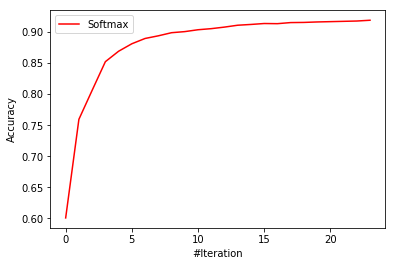

In [166]:
accuracy, preds, rrr = main(Train, train_categ, Valid, valid_categ, 0, 365, 0.005, opt =4)
print("Accuracy: %.3f" % accuracy)
softmax, = plt.plot(list(range(len(rrr))), rrr, label = 'Softmax', color = 'red')
plt.xlabel('#Iteration')
plt.ylabel('Accuracy')
plt.legend(handles = [softmax])
plt.show()

# Words with largest coefficients

In [169]:
W = main(Train, train_categ, Valid, valid_categ, 0, 365, 0.005, opt =3)
W.shape

(17062, 5)

In [200]:
vocabulary = vect.vocabulary_
inverse = {v:k for k,v in vocabulary.items() }
clas = ['Technology','Entertainment & Arts','Business','Health','Science & Environment']
for i in range(5):
    a = np.array(W[:,i].transpose())[0].argsort()[-10:][::-1]
    print(clas[i], [inverse[i] for i in a])
    

Technology ['googl', 'user', 'game', 'site', 'comput', 'devic', 'firm', 'network', 'attack', 'app']
Entertainment & Arts ['film', 'star', 'album', 'art', 'award', 'music', 'actor', 'artist', 'play', 'theatr']
Business ['bank', 'busi', 'compani', 'market', 'custom', 'profit', 'price', 'financi', 'share', 'growth']
Health ['nh', 'health', 'patient', 'hospit', 'care', 'treatment', 'diseas', 'cancer', 'england', 'medic']
Science & Environment ['scienc', 'climat', 'scientist', 'space', 'rocket', 'earth', 'satellit', 'mission', 'orbit', 'carbon']


# precision, recall, F-measure 

In [58]:
from sklearn.metrics import classification_report
print(classification_report(valid_categ, preds))

             precision    recall  f1-score   support

          0       0.88      0.91      0.90      1165
          1       0.96      0.97      0.96       727
          2       0.92      0.91      0.92      1620
          3       0.97      0.94      0.95       193
          4       0.92      0.87      0.90       286

avg / total       0.92      0.92      0.92      3991



# Evaluation: Confusion Matrix

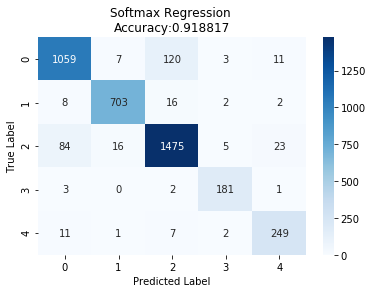

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
confusion = pd.DataFrame(confusion_matrix(preds, valid_categ))
sns.heatmap(confusion, annot = True, fmt="d", cmap="Blues")
plt.title("Softmax Regression \nAccuracy:{0:3f}".format(accuracy_score(preds, valid_categ)))
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Predict by TimeSeries

In [161]:
def ReservoirSample(data, categ, newdata, newcateg):
    k = len(data)
    n = len(newdata)
    for i in range(n):
        j = randint(0, i+k-1)  
        if j < n:
            data[j] = newdata[i]
            categ[j] = newcateg[i]
    return data,categ

In [159]:
def use_soft_indiv(data, categ, retrain = 0):
    # retrain = 0: no retrain
    #           1: use true to retrain
    #           2: use predict to retrain
    # Record all of the predictions
    predicts = []
    size = len(data)//60
    if retrain == 1:
        
        for j in range(0, len(data)-size*2, size):
            T,V = tfidf(data[0:j+size], data[j+size:j+2*size])
            predicts.append(main(T, categ[0:j+size], V, categ[j+size:j+2*size], 0, 365, 0.05, 0))
    
    elif retrain == 2:
        pred_categ = categ[0:size]
        for j in range(0, len(data)-size*2, size):
            T,V = tfidf(data[0:j+size], data[j+size:j+2*size])
            rate, preds = main(T, pred_categ[0:j+size], V, categ[j+size:j+2*size], 0, 365, 0.01,1) 
            pred_categ.extend(preds)
            predicts.append(rate)
            
    elif retrain == 3:
        sample_categ = categ[0:size*2]
        sample_data = data[0:size*2]
        for j in range(0, len(data)-size*2, size):
            #print(len(sample_data))
            T,V = tfidf(sample_data, data[j+size:j+2*size])
            
            rate, preds = main(T, sample_categ , V, categ[j+size:j+2*size], 0, 365, 0.01, 1)
            
            sample_data, sample_categ = ReservoirSample(sample_data, sample_categ, data[j+size:j+2*size], preds)
            #print(sample_categ[1])
            predicts.append(rate)
    elif retrain == 4:
        sample_categ = categ[0:size*2]
        sample_data = data[0:size*2]
        for j in range(0, len(data)-size*2, size):
            T,V = tfidf(data[0:j+size], data[j+size:j+2*size])
            predicts.append(main(T, categ[0:j+size], V, categ[j+size:j+2*size], 0, 365, 0.05, 0))
            sample_data, sample_categ = ReservoirSample(sample_data, sample_categ, data[j+size:j+2*size], preds)
        
    else:
        for j in range(0, len(data)-size*2, size):
            T,V = tfidf(data[0:size], data[j+size:j+2*size])
            predicts.append(main(T, categ[0:size], V, categ[j+size:j+2*size], 0, 365, 0.05, 0))
    
    return predicts

In [162]:
# use Reservoir Sample
res4 = use_soft_indiv(articles, categ,  3)

In [98]:
# no retrain
res1 = use_soft_indiv(articles, categ,  0)

In [100]:
# use true to retrain
res2 = use_soft_indiv(articles, categ,  1)

In [128]:
# use predict to retrain
res3 = use_soft_indiv(articles, categ,  2)

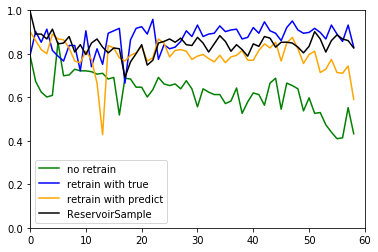

In [164]:
no_retrain_line,           = plt.plot(list(range(len(res1))), res1, label = 'no retrain', color = 'green')
plt.xlim(0,60)
plt.ylim(0,1)
retrain_with_true_line,    = plt.plot(list(range(len(res2))), res2, label = 'retrain with true', color = 'blue')
retrain_with_predict_line, = plt.plot(list(range(len(res3))), res3, label = 'retrain with predict', color = 'orange')
ReservoirSample_line,           = plt.plot(list(range(len(res4))), res4, label = 'ReservoirSample', color = 'black')
plt.legend(handles = [no_retrain_line, retrain_with_true_line, retrain_with_predict_line, ReservoirSample_line])
plt.show()